# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

## Исследовательский анализ данных

In [1]:
# загружаем и импортируем все библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# загружаем датафрейм с целевым признаком возраст и названием фотографии
df = pd.read_csv('/datasets/faces/labels.csv')
df.info()
df.head()

df.to_csv('labels.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# извлекаем фотографии из папки загрузчиком
datagen = ImageDataGenerator(rescale=1./255)
photos = datagen.flow_from_dataframe(dataframe = df, directory = '/datasets/faces/final_files/', 
                                     x_col='file_name', y_col='real_age', class_mode='raw', 
                                     target_size=(150, 150), batch_size=32, seed=42)

Found 7591 validated image filenames.


In [5]:
# посмотрим на статистику распределния возраста в наших данных
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [6]:
# посчитаем количество уникальных лет
num_labels = len(np.unique(df['real_age'].values))

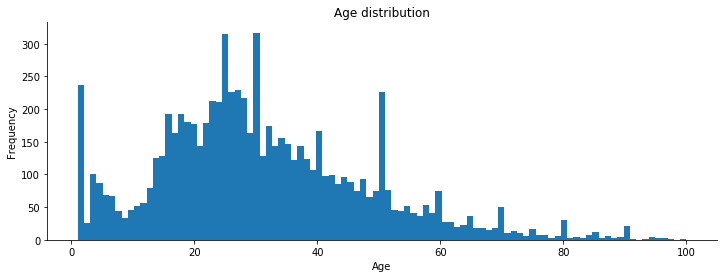

In [11]:
# посмотрим распределение возраста по всей выборке
_ = df.plot(kind='hist', bins=num_labels, figsize=(12,4), title='Age distribution', legend=False)
sns.despine()
plt.xlabel('Age')
plt.show()

In [16]:
# получим объекты с парами "картинки-метки"
features, target = next(photos)

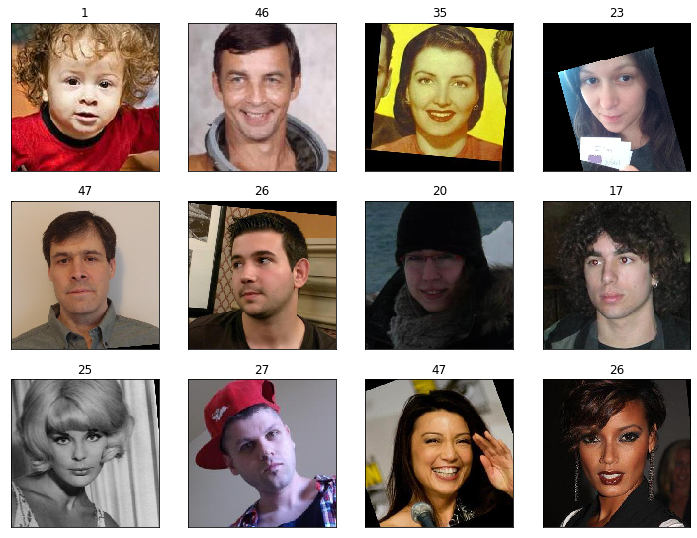

In [22]:
# выведем первые 12 изображений с возрастом каждого человека
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(target[i])

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_test(path=None):
    labels = pd.read_csv('/datasets/faces/labels.csv')

    datagen_test = ImageDataGenerator(rescale=(1.0/255.0), validation_split=0.2)

    test_datagen_flow = datagen_test.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def load_train(path=None):
    labels = pd.read_csv('/datasets/faces/labels.csv')

    datagen_train = ImageDataGenerator(rescale=(1.0/255.0), validation_split=0.2, rotation_range=15, 
                                  width_shift_range=0.2, height_shift_range=0.2)

    train_datagen_flow = datagen_train.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate = 0.0003)

    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_datagen_flow, val_datagen_flow, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch == None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps == None:
        validation_steps = len(val_datagen_flow)

    model.fit(train_datagen_flow,  
              validation_data=val_datagen_flow,
              steps_per_epoch=steps_per_epoch, 
              epochs=epochs,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```
Train for 380 steps, validate for 95 steps
Epoch 1/30
2021-04-11 21:59:52.605919: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-11 21:59:52.917558: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
380/380 - 113s - loss: 188.3044 - mae: 10.4003 - val_loss: 323.4938 - val_mae: 13.3573
Epoch 2/30
380/380 - 105s - loss: 129.8981 - mae: 8.6494 - val_loss: 169.4789 - val_mae: 10.1733
Epoch 3/30
380/380 - 105s - loss: 104.5122 - mae: 7.7592 - val_loss: 151.5517 - val_mae: 9.4819
Epoch 4/30
380/380 - 105s - loss: 93.6560 - mae: 7.3799 - val_loss: 136.5824 - val_mae: 8.9604
Epoch 5/30
380/380 - 105s - loss: 84.7110 - mae: 7.0324 - val_loss: 124.7602 - val_mae: 8.5726
Epoch 6/30
380/380 - 105s - loss: 73.0725 - mae: 6.4869 - val_loss: 93.5210 - val_mae: 7.3132
Epoch 7/30
380/380 - 105s - loss: 69.0768 - mae: 6.3207 - val_loss: 87.6563 - val_mae: 6.9912
Epoch 8/30
380/380 - 105s - loss: 62.4609 - mae: 5.9818 - val_loss: 116.2937 - val_mae: 8.2036
Epoch 9/30
380/380 - 105s - loss: 58.8607 - mae: 5.8982 - val_loss: 81.8312 - val_mae: 6.8575
Epoch 10/30
380/380 - 105s - loss: 53.7384 - mae: 5.6208 - val_loss: 123.4070 - val_mae: 8.5818
Epoch 11/30
380/380 - 105s - loss: 51.9280 - mae: 5.5117 - val_loss: 91.0506 - val_mae: 7.1193
Epoch 12/30
380/380 - 105s - loss: 47.7941 - mae: 5.3120 - val_loss: 85.8121 - val_mae: 6.9002
Epoch 13/30
380/380 - 104s - loss: 45.4607 - mae: 5.1996 - val_loss: 102.8038 - val_mae: 7.4268
Epoch 14/30
380/380 - 106s - loss: 45.4404 - mae: 5.1731 - val_loss: 96.5816 - val_mae: 7.3164
Epoch 15/30
380/380 - 105s - loss: 40.7108 - mae: 4.8997 - val_loss: 109.5658 - val_mae: 7.7827
Epoch 16/30
380/380 - 105s - loss: 39.3013 - mae: 4.8221 - val_loss: 120.4824 - val_mae: 7.9052
Epoch 17/30
380/380 - 106s - loss: 37.4467 - mae: 4.7077 - val_loss: 143.1041 - val_mae: 9.1476
Epoch 18/30
380/380 - 105s - loss: 33.7012 - mae: 4.4527 - val_loss: 81.7639 - val_mae: 6.4927
Epoch 19/30
380/380 - 105s - loss: 30.9812 - mae: 4.3034 - val_loss: 117.4145 - val_mae: 7.8748
Epoch 20/30
380/380 - 106s - loss: 27.6808 - mae: 4.0437 - val_loss: 78.0343 - val_mae: 6.4689
Epoch 21/30
380/380 - 104s - loss: 32.9308 - mae: 4.4082 - val_loss: 97.5086 - val_mae: 7.5360
Epoch 22/30
380/380 - 105s - loss: 28.9429 - mae: 4.1490 - val_loss: 80.7892 - val_mae: 6.5193
Epoch 23/30
380/380 - 105s - loss: 27.6257 - mae: 3.9871 - val_loss: 68.9201 - val_mae: 6.1876
Epoch 24/30
380/380 - 104s - loss: 26.3554 - mae: 3.9381 - val_loss: 119.2237 - val_mae: 8.3826
Epoch 25/30
380/380 - 104s - loss: 27.2226 - mae: 4.0264 - val_loss: 100.4099 - val_mae: 7.5972
Epoch 26/30
380/380 - 105s - loss: 22.7500 - mae: 3.7204 - val_loss: 86.8299 - val_mae: 6.9220
Epoch 27/30
380/380 - 104s - loss: 23.5283 - mae: 3.7448 - val_loss: 78.7976 - val_mae: 6.4259
Epoch 28/30
380/380 - 105s - loss: 20.5491 - mae: 3.4960 - val_loss: 97.7179 - val_mae: 6.9078
Epoch 29/30
380/380 - 105s - loss: 20.2073 - mae: 3.4714 - val_loss: 77.6730 - val_mae: 6.5762
Epoch 30/30
380/380 - 105s - loss: 16.1633 - mae: 3.1278 - val_loss: 78.5716 - val_mae: 6.3116

```

## Анализ обученной модели

1. Величина MAE модели на тестовой выборке составила 6 лет.
2. Приемлевого качества нейронная сеть достигла к 20-й эпохе. Можно было бы сократить время обучения.
3. Learning_rate установлен на 0.0003.
4. Обучение нейронной сети заняло около часа.
5. Для учета поворота фотографий rotation_range установлено на 15 градусов, также было задано 20%-е смещение по вертикали и горизонтали.


## Общий вывод

Что мы сделали:
- Загрузили таблицу с с целевым признаком возраст, названием фотографии и изучили данные: всего 7591 наблюдений без пропусков. Средний возраст - 30 лет и 75% обладателей лиц возрастом до 40 лет. При этом имеются 4 пика: годовалые дети, примерно 23, 26 и 41-летние;
- Также извлекли фотографии из папки и объединили с таргетом, вывод первых 12 кадров показал, что данные с аугментацией: имеются резкие/вытянутые изображения, распределение по полу данной выборке пропорционально и большинство, видимо, белые;
- Обучили на наших данных нейронную сеть с 30 эпохами. Построенная модель позволяет определять возраст покупателя со средней абсолютной ошибкой в 6 лет

Полученное значение средней абсолютной ошибки возможно недостаточно для адекватной оценки возраста покупателей. Ошибка в 6 лет средняя величина и уже позволяет определить возраст человека и дать хороший результат. Возможно стоит дополнить выборку фотографиями людей младше 30 лет, а также проверить полученную модель, исходя из поставленной задачи, только на фотографиях людей от 11 до 25 лет.

Также, я бы попробовал:
- сделать весь датасет черно-белым, и в продакшене цветные изображения переведить в ч/б;
- обрезать края изображений,
- возможно стоит попробовать исключить из датасета изображения низкого качества, или даже ранжировать их, и попробовать обучать модели сначала с наилучшим разрешением, постепенно добавляя к ним все более худшие. Можно, например, это сделать перебрав числовое представление каждого изображения. На изображениях в меньшем, чем размер картинки, разрешении, значения векторов соседних пикселей (группа пикселей NxN, причем N будет характеризовать то во сколько раз разрешение меньше разрешения изображения) должны быть равны, причем данные группы одинаковых векторов должны быть равномерно распределены по изображению и для всего изображения иметь равный размер.Таким же образом можно отсеить растянутые или вытянутые изображения (когда группа пикселей MxN и M!=N).
